In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyvista as pv
from scipy.spatial import ConvexHull, Voronoi
import seaborn as sns
import shapely
import shapely.geometry
import shapely.ops
from sklearn.cluster import KMeans
import trimesh
import trimesh.creation as tc
sns.set()

In [11]:
stl_poly_name = "viet"
stl_poly_mesh = pv.read('./viet/V2_2_105.75_15.98_tile_1_1.stl')
stl_poly_plane = stl_poly_mesh.project_points_to_plane().points
stl_poly_edge = stl_poly_mesh.project_points_to_plane().extract_feature_edges().points
stl_poly_bounds = stl_poly_mesh.bounds

n_pieces = 16

In [12]:
kmeans = KMeans(n_clusters=n_pieces, random_state=0).fit(stl_poly_plane[:,:2])
clusters = kmeans.predict(stl_poly_plane[:,:2])
vor = Voronoi(kmeans.cluster_centers_, qhull_options='Qbb Qc Qx')

region_bbox = shapely.geometry.Polygon(zip(
    [stl_poly_plane[:,0].min()-5, stl_poly_plane[:,0].min()-5, stl_poly_plane[:,0].max()+5, stl_poly_plane[:,0].max()+5, stl_poly_plane[:,0].min()-5], 
    [stl_poly_plane[:,1].min()-5, stl_poly_plane[:,1].max()+5, stl_poly_plane[:,1].max()+5, stl_poly_plane[:,1].min()-5, stl_poly_plane[:,1].min()-5]
))

In [13]:
stl_poly_plane_df = pd.DataFrame(stl_poly_plane, columns=['x','y','z'])
stl_poly_plane_df['cluster'] = clusters

pieces = []
for g, gdf in stl_poly_plane_df.groupby('cluster'):
    hull = ConvexHull(gdf[['x','y']].values)
    p = hull.points[hull.vertices]    
    poly = shapely.geometry.Polygon(p)
    pieces.append(poly)

In [14]:
stl_poly_plane_df = pd.DataFrame(stl_poly_plane, columns=['x','y','z'])
stl_poly_plane_df['cluster'] = clusters

pieces = []
for g, gdf in stl_poly_plane_df.groupby('cluster'):
    hull = ConvexHull(gdf[['x','y']].values)
    p = hull.points[hull.vertices]    
    poly = shapely.geometry.Polygon(p)
    pieces.append(poly)
    
connected_pieces = []
for idx, p0 in enumerate(pieces):
    for jdx, p1 in enumerate(pieces[idx+1:], idx+1):
        if idx == jdx: continue
        line = shapely.geometry.LineString([p0.centroid, p1.centroid])
        poly_intersections = [(i, line.intersection(p).length) for i, p in enumerate(pieces) if line.intersects(p)]
        if len(poly_intersections) == 2:
            if (poly_intersections[0][1] + poly_intersections[1][1]) / line.length > 0.7:
                connected_pieces.append([(i,pieces[i].centroid.coords[0]) for i, length in poly_intersections])
        
for (i, c0),(j,c1) in connected_pieces:
    line = shapely.geometry.LineString([c0, c1])
    near_center_point = line.interpolate(0.65, normalized=True)
    near_center_point_poly = shapely.geometry.LineString([line.coords[0], near_center_point]).buffer(0.5)
    near_center_point_buffer = near_center_point.buffer(1.5)
    x, y = near_center_point_buffer.exterior.xy
    
    x.append(x[0])
    y.append(y[0])
    near_center_point_buffer = shapely.geometry.Polygon(zip(x[::3],y[::3]))
    near_center_point_poly = shapely.ops.cascaded_union([near_center_point_poly, near_center_point_buffer])
    
    pieces[i] = shapely.ops.cascaded_union([pieces[i], near_center_point_poly]).buffer(0)
    pieces[j] = pieces[j].difference(near_center_point_poly.buffer(0.4))

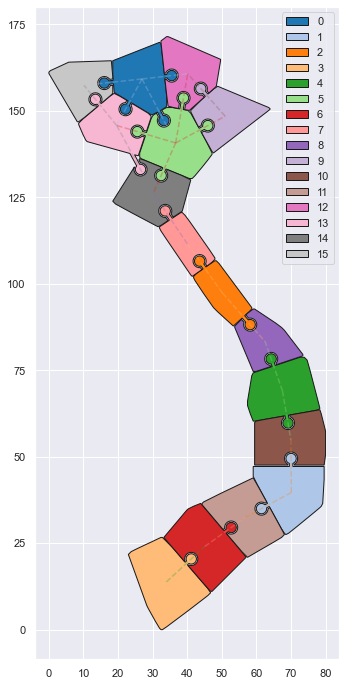

In [15]:
fig, ax = plt.subplots(1, figsize=(16,12))
# ax.scatter(stl_poly_plane[:,0], stl_poly_plane[:,1], c=clusters, alpha=1, s=10)
# ax.scatter(stl_poly_edge[:,0], stl_poly_edge[:,1], alpha=0.4)
c = plt.cm.tab20.colors
for idx, p in enumerate(pieces):
    try:
        x, y = p.exterior.xy
#     plt.plot(x,y,lw=3,ls='--', c=c[idx%len(c)])
        plt.fill(x,y, c=c[idx%len(c)], label=f'{idx}', edgecolor='k')
    except:
        print(idx, 'multipoly')
        for m in p:
            x, y = m.exterior.xy
            plt.fill(x,y, c=c[idx%len(c)], label=f'{idx}', edgecolor='k')

for idx, (c0, c1) in enumerate(connected_pieces):
    i,(x0,y0) = c0
    j,(x1,y1) = c1
    plt.plot([x0,x1], [y0,y1], ls='--', c=c[(i+1)%len(c)], alpha=0.3)

    
            
plt.legend()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

Pieces/0001_0016


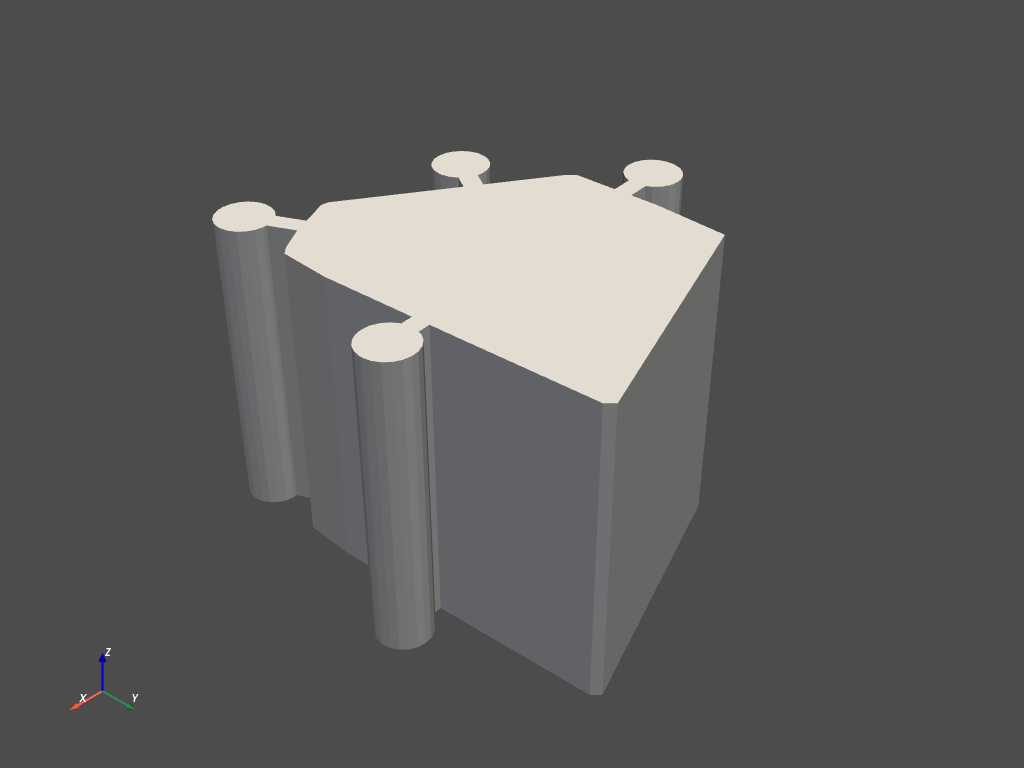

Pieces/0002_0016


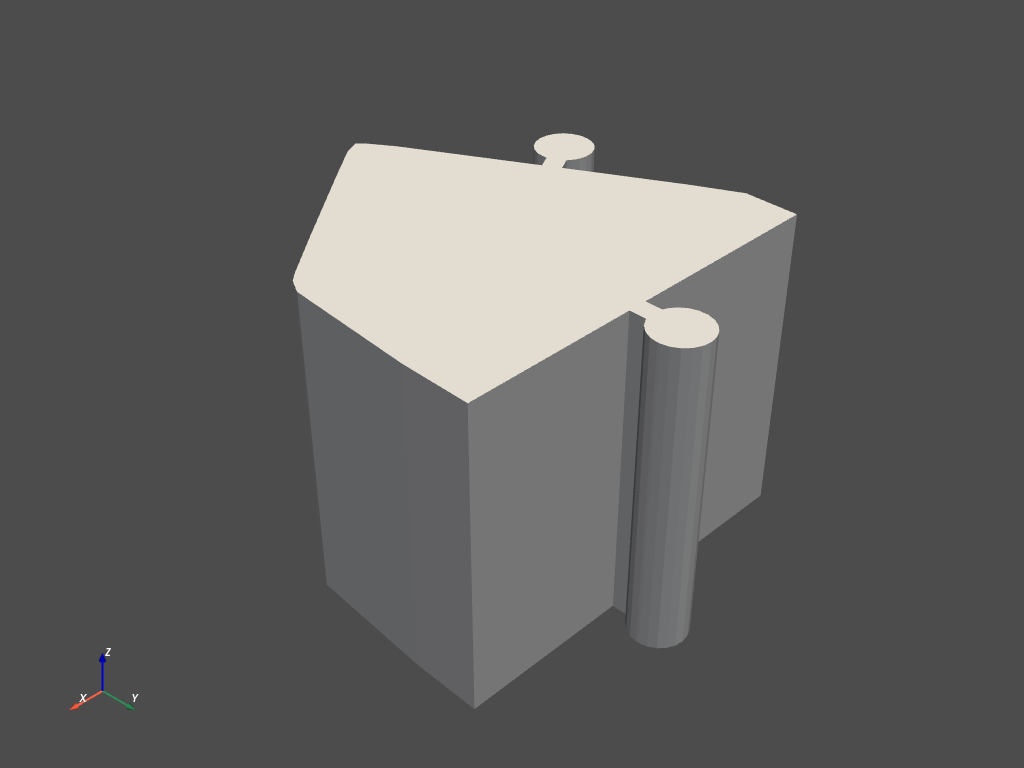

Pieces/0003_0016


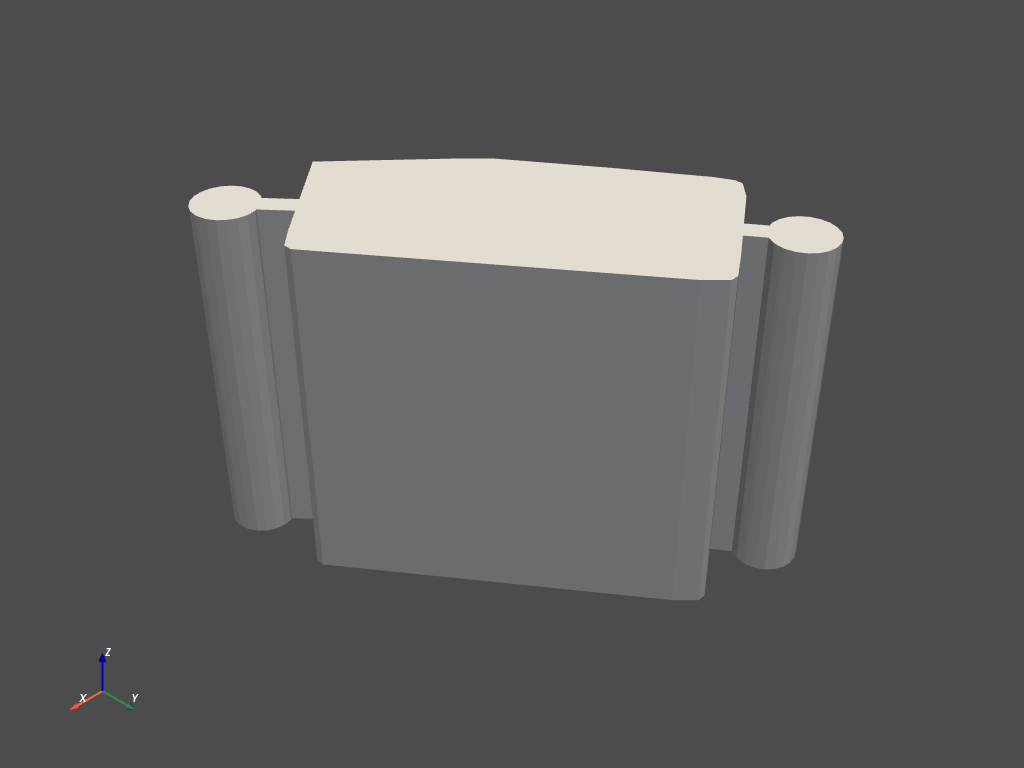

Pieces/0004_0016


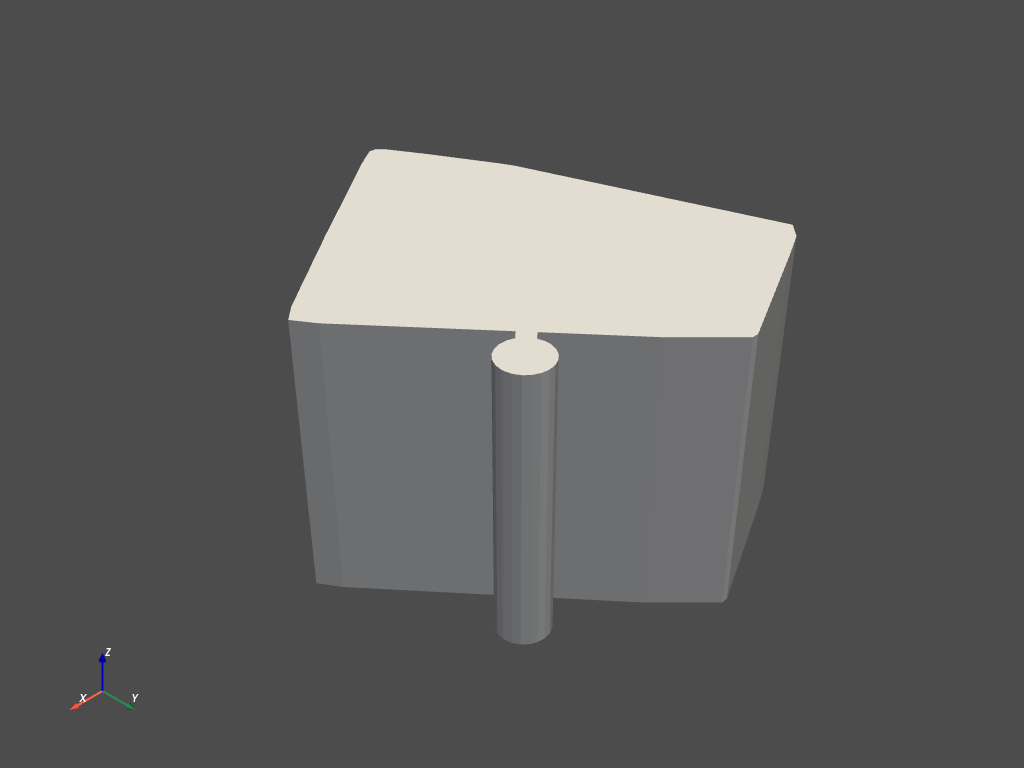

Pieces/0005_0016


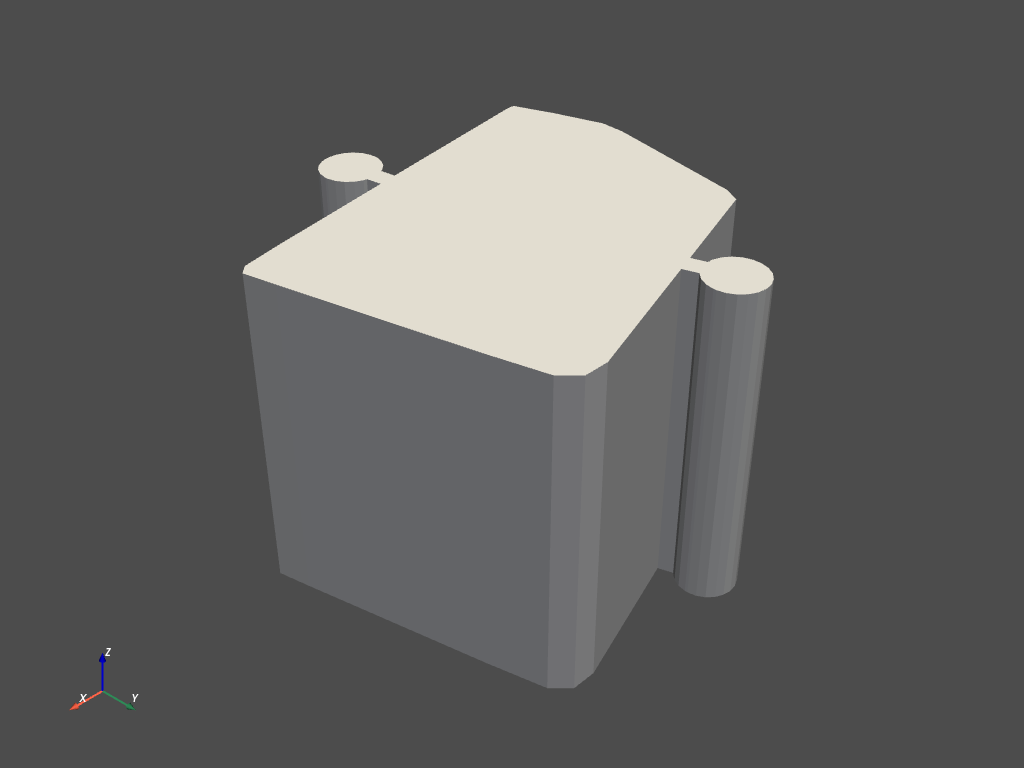

Pieces/0006_0016


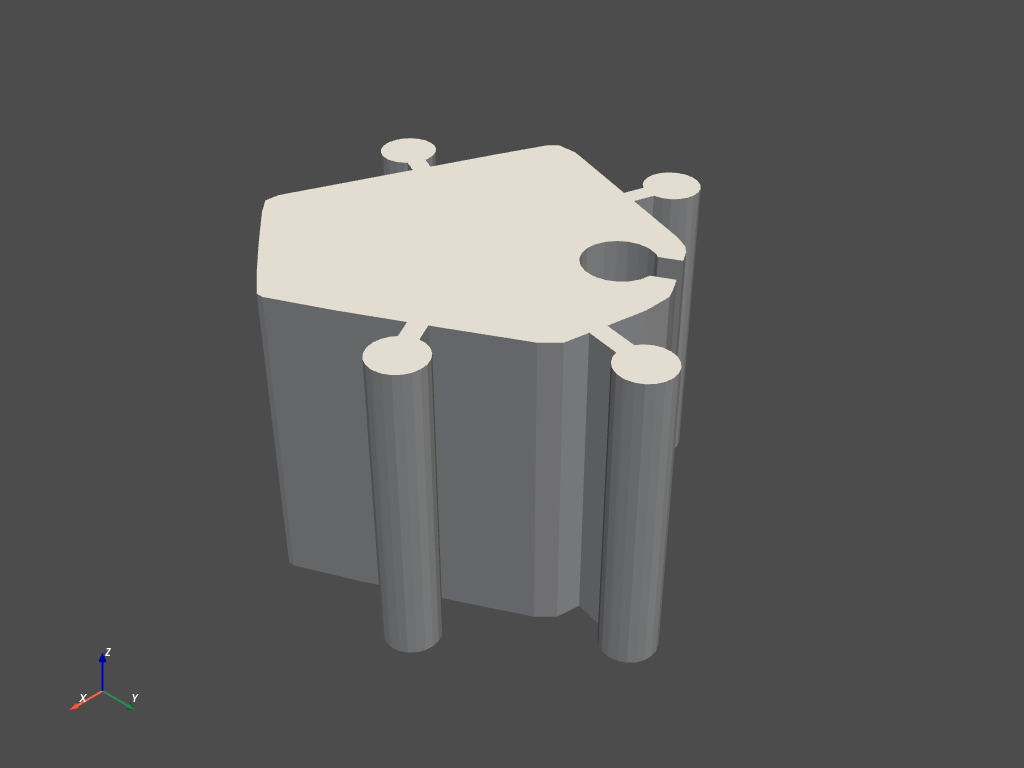

Pieces/0007_0016


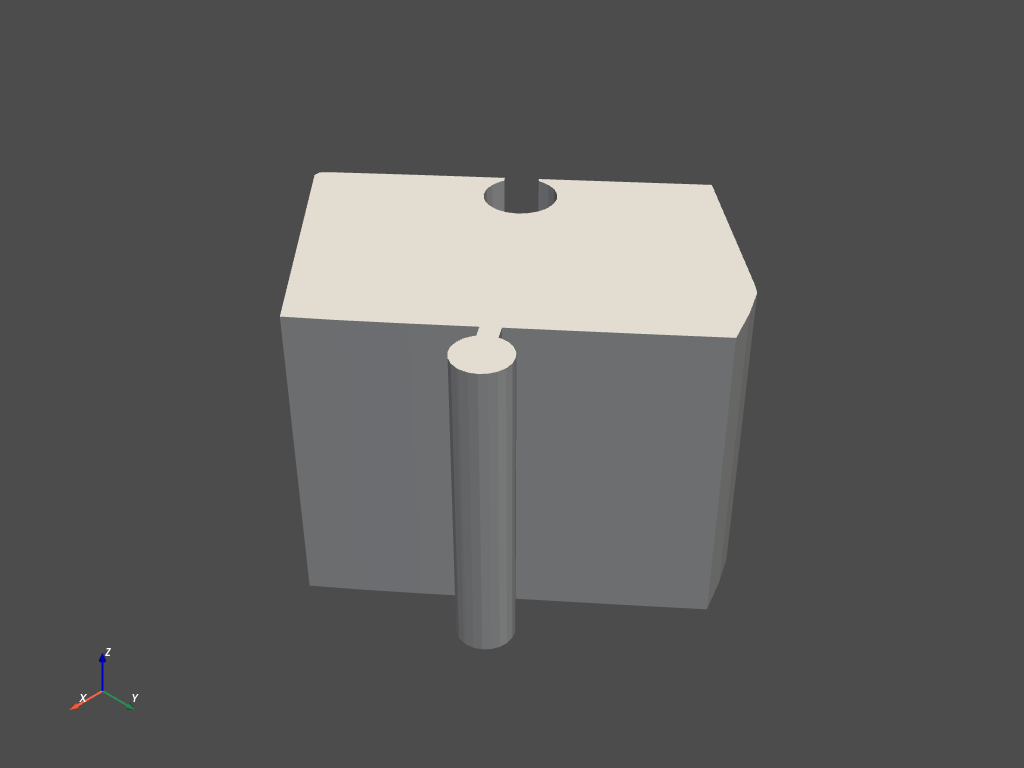

Pieces/0008_0016


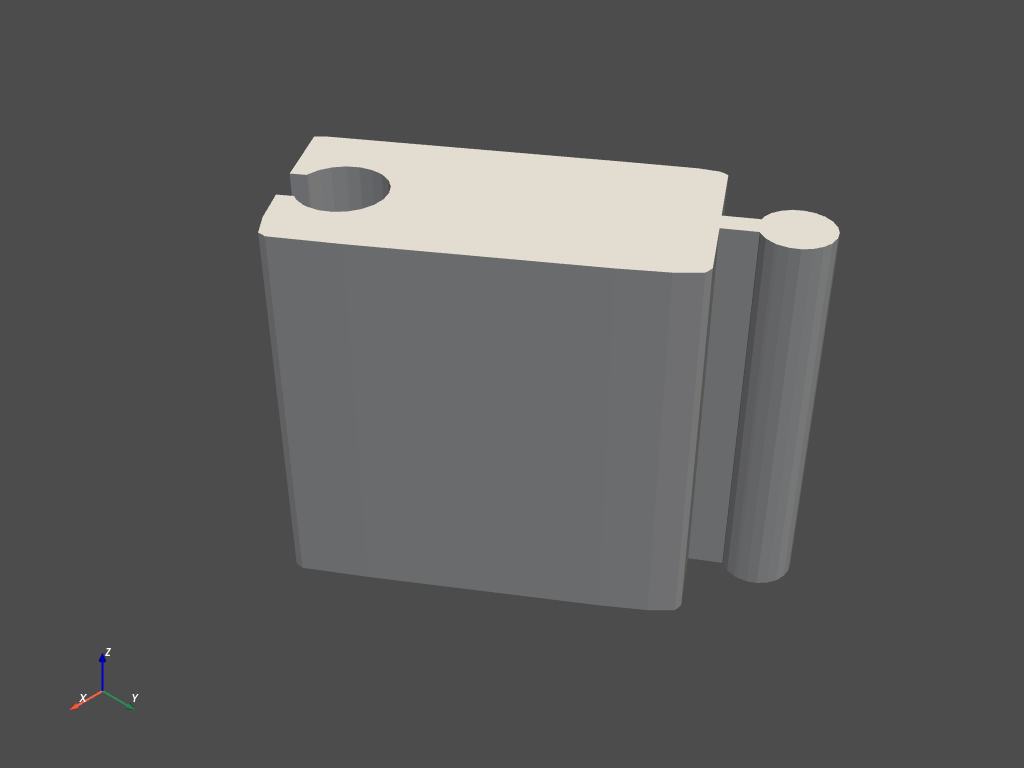

Pieces/0009_0016


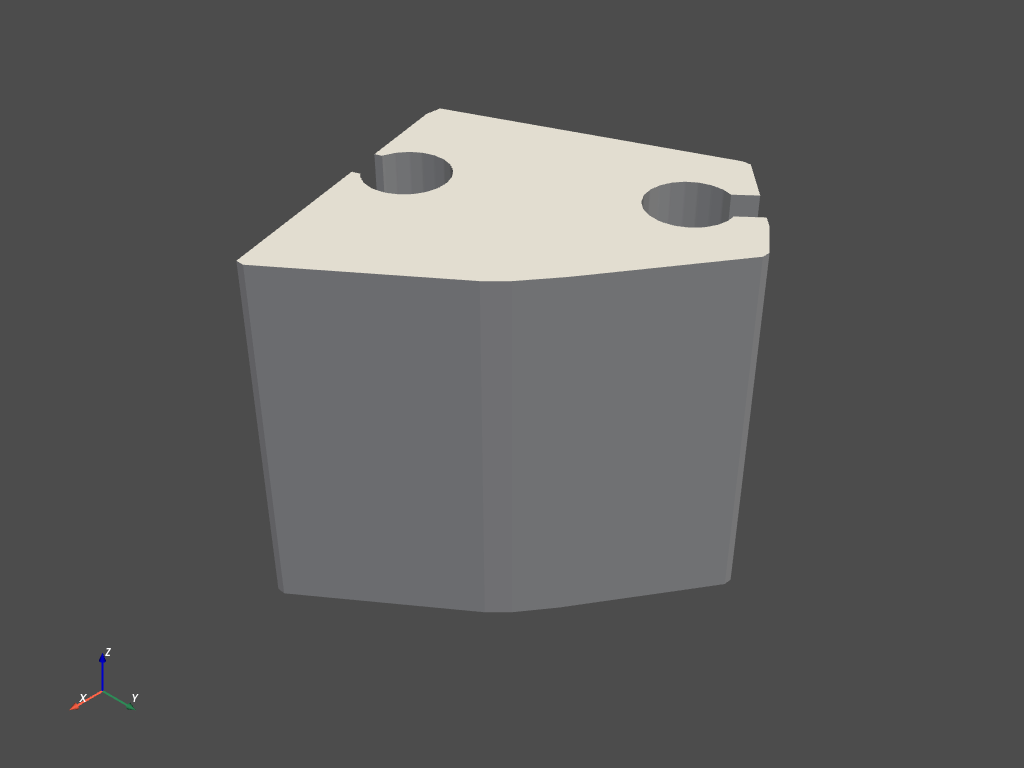

Pieces/0010_0016


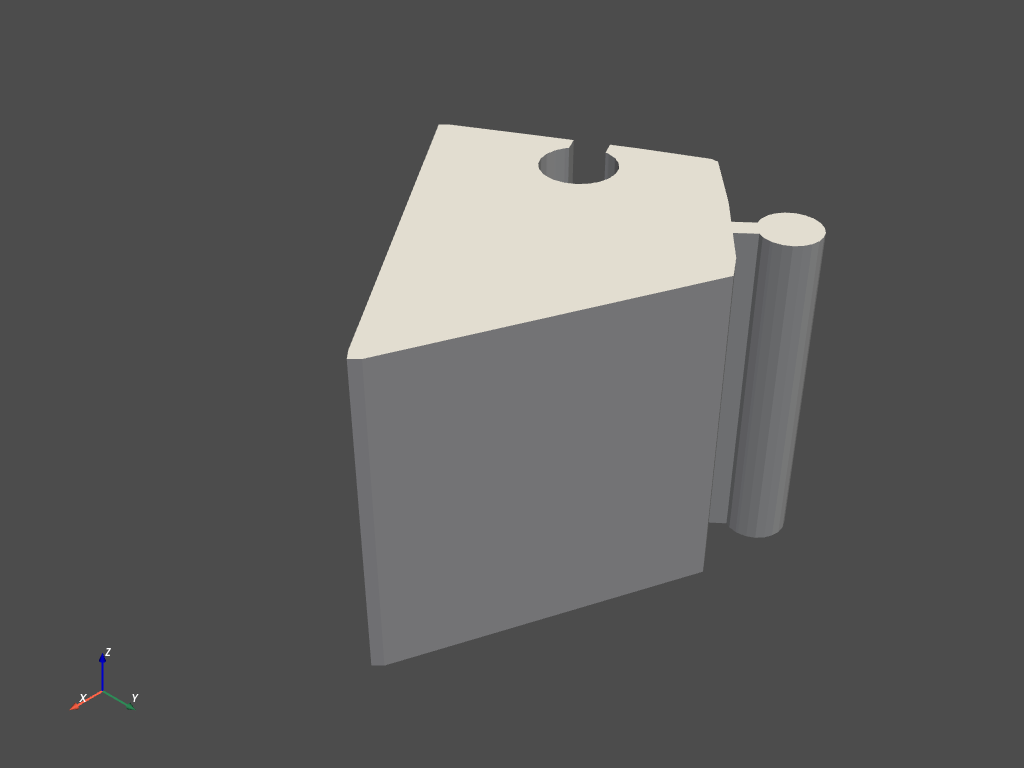

Pieces/0011_0016


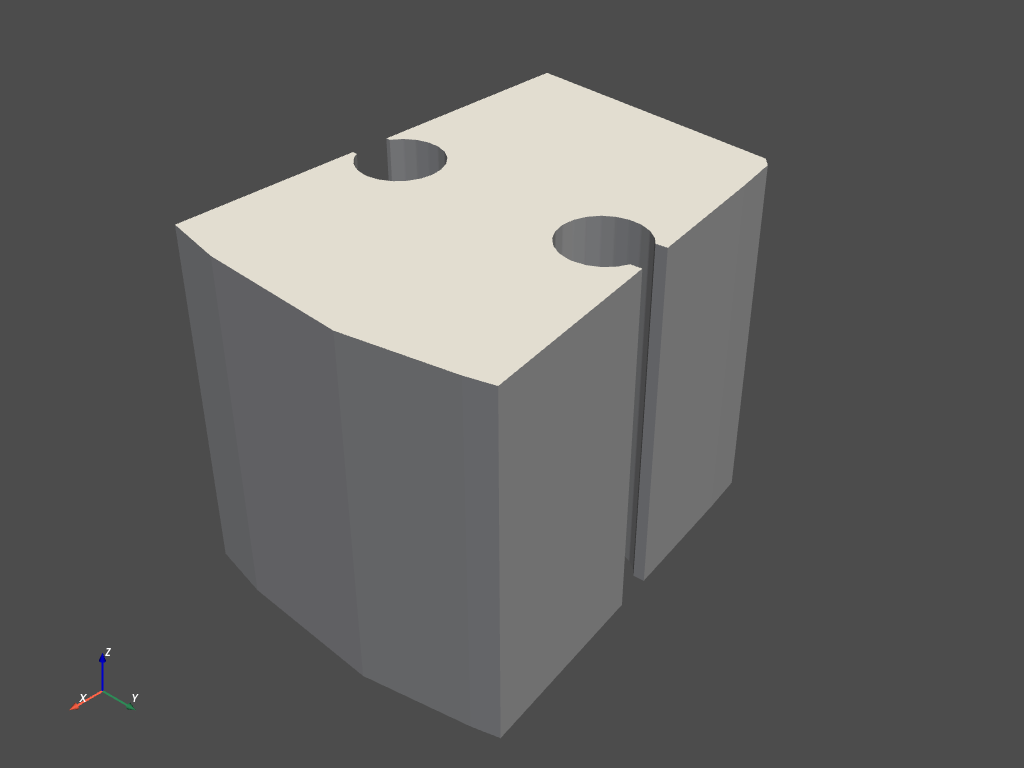

Pieces/0012_0016


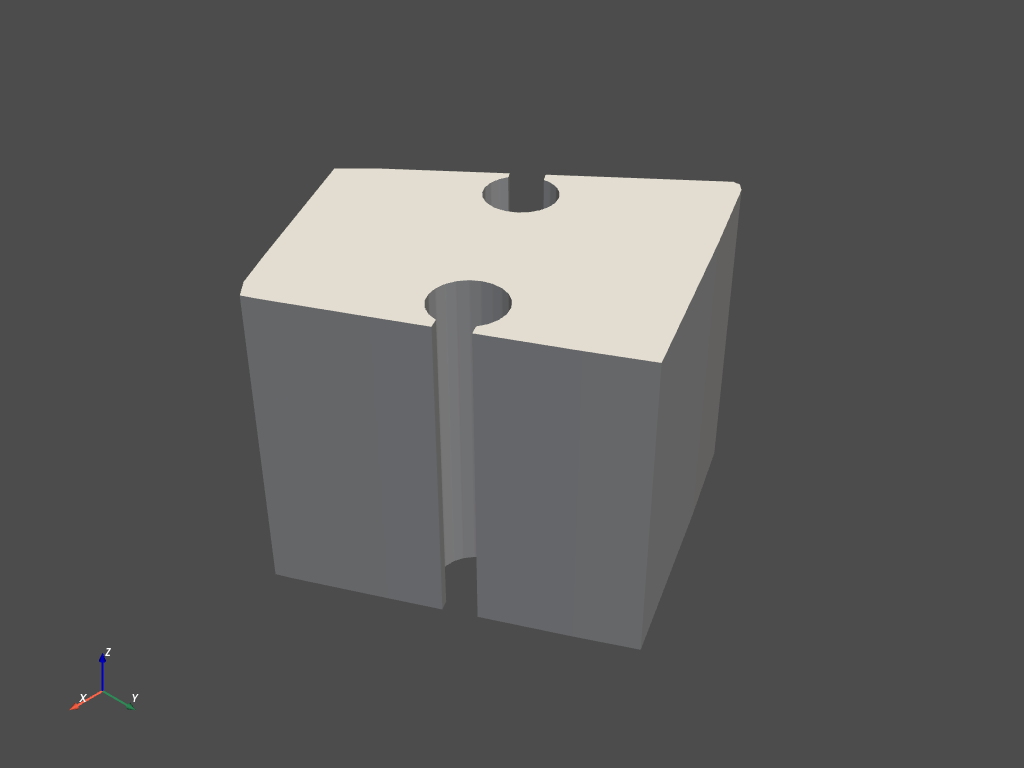

Pieces/0013_0016


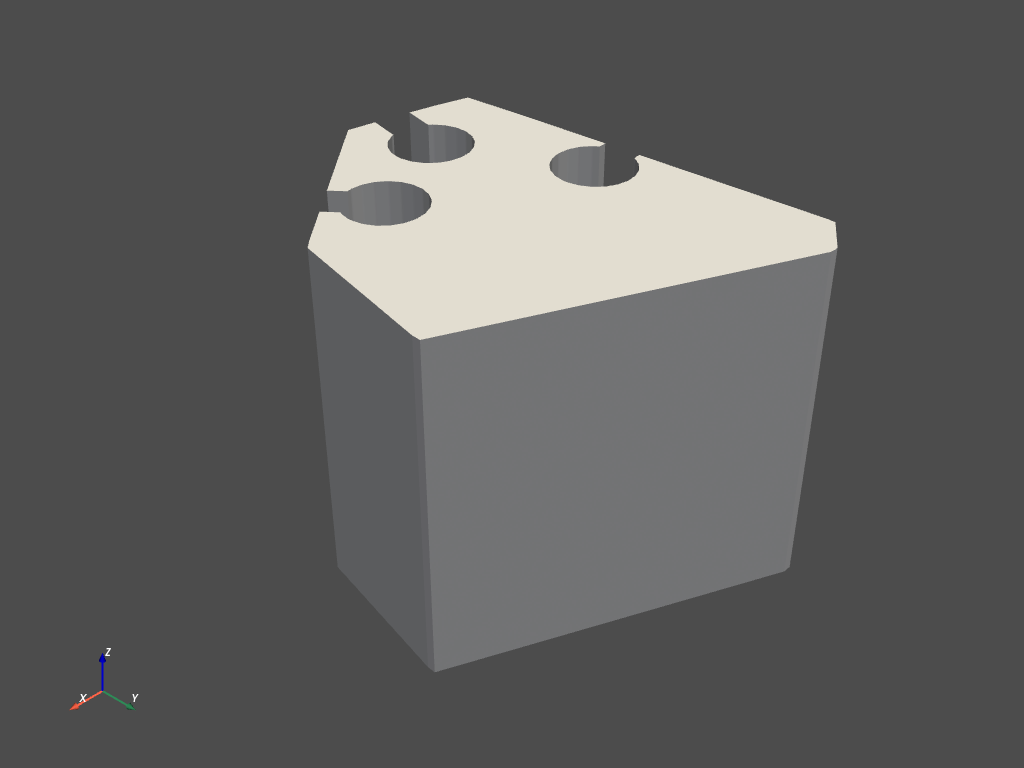

Pieces/0014_0016


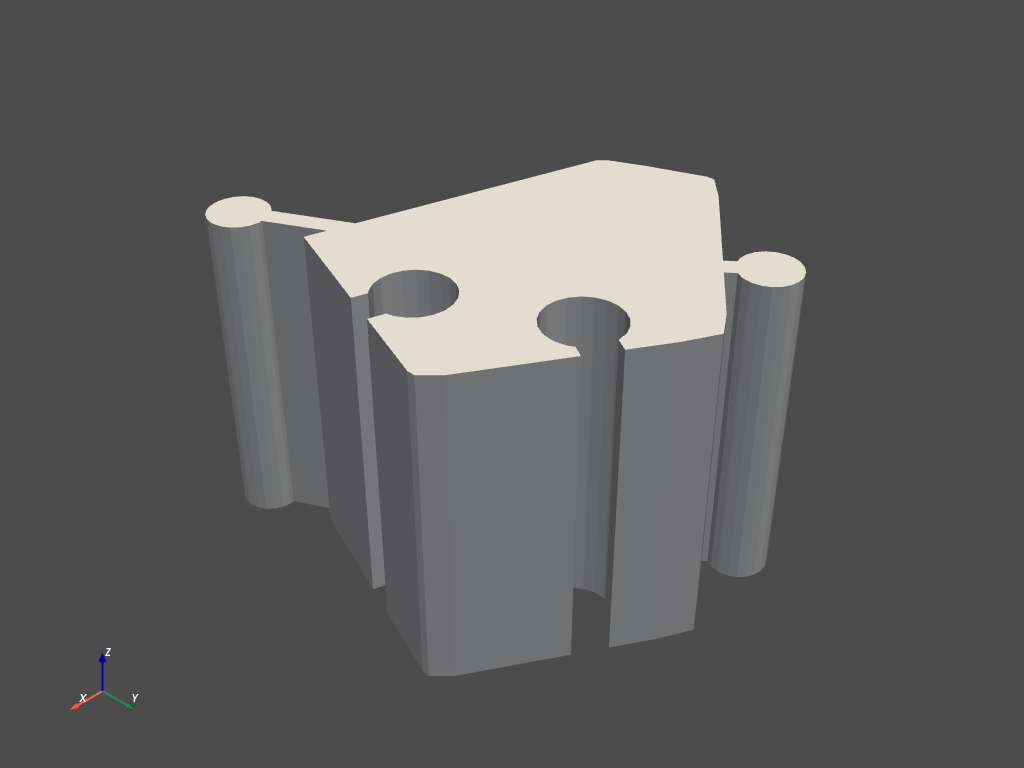

Pieces/0015_0016


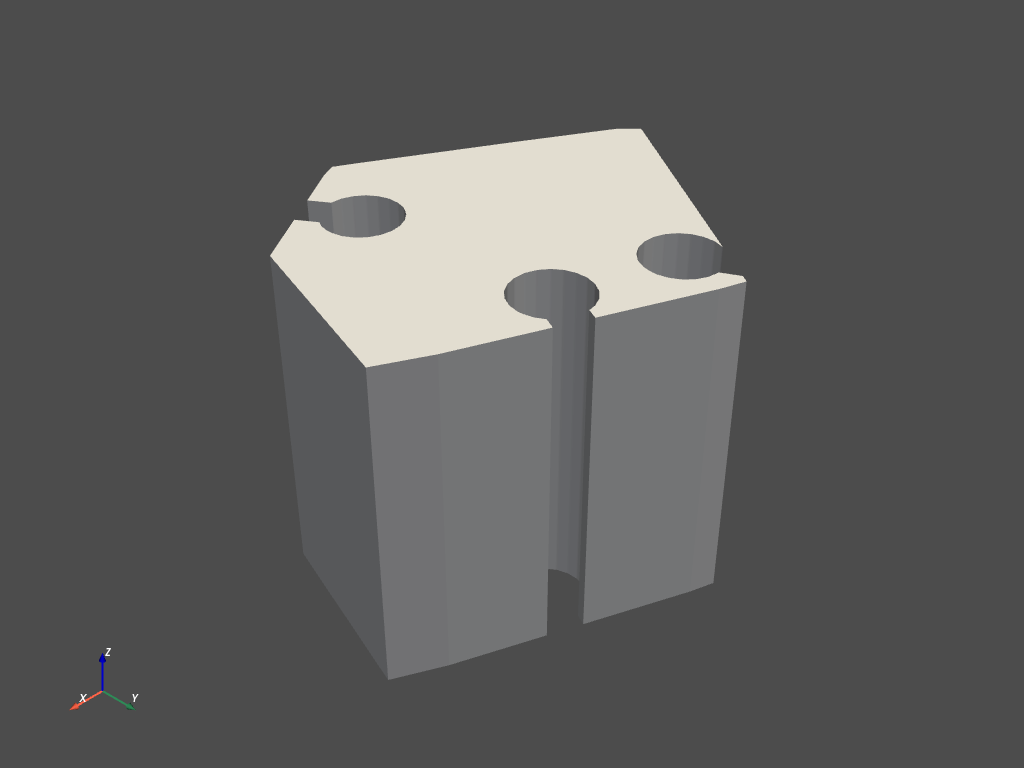

Pieces/0016_0016


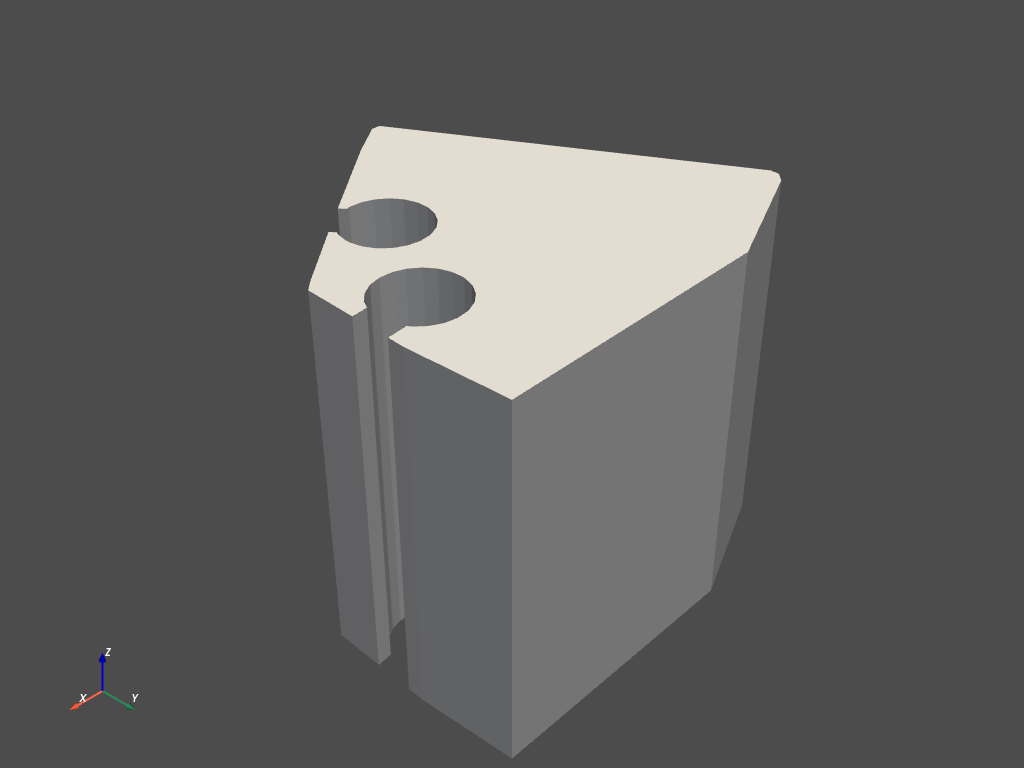

In [16]:
for idx, p in enumerate(pieces):
    print(f"Pieces/{idx+1:04}_{len(pieces):04}")
    piece = tc.extrude_polygon(p, 1)
    piece = piece.apply_transform(
        trimesh.transformations.scale_and_translate(
            scale=[1,1,stl_poly_bounds[5]+2], 
            translate=[0,0,-1]
        )
    )
    piece = pv.wrap(piece)
    piece.plot()
    vox = pv.voxelize(piece, density=3)
    piece = vox.clip_surface(stl_poly_mesh).extract_surface()

    piece.save(f"Pieces/{stl_poly_name}_{idx+1:04}_{len(pieces):04}.stl")

In [ ]:
assert
mesh_pieces = []
for idx, p in enumerate(pieces):
    mesh_piece = []
    for t in tc.extrude_polygon(p, 1).triangles:
        t = np.vstack([t, [t[0]]])
        mesh_piece.append(t)
        plt.plot(t[:,0], t[:,1])
    mesh_pieces.append(mesh_piece)
    plt.show()